In [90]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import regularizers

from keras import backend as K 

import matplotlib.pyplot as plt

K.clear_session()

In [91]:
from keras import backend as K
K.clear_session()

### Setting Up GPU as a training device

In [92]:
physical_devices = tf.config.list_physical_devices()

print(physical_devices)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [93]:
tf.config.set_visible_devices(physical_devices[1], 'GPU')

### Loading Data

In [94]:
N_TRAIN_EXAMPLES = 60000
N_VALIDATION_EXAMPLES = 0
N_TEST_EXAMPLES = 10000

CLASSES=10

In [95]:

from sklearn.model_selection import train_test_split

(X_train, Y_train), (X_test, Y_test) = keras.datasets.mnist.load_data()

X_train

# Concatenate train and test images
X = np.concatenate((X_train, X_test))
y = np.concatenate((Y_train, Y_test))

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=N_TRAIN_EXAMPLES+N_VALIDATION_EXAMPLES, test_size=N_TEST_EXAMPLES, random_state=1)

# Getting dummy variables
y_train_fixed = np.zeros((y_train.shape[0], CLASSES))
y_test_fixed = np.zeros((y_test.shape[0], CLASSES))

i = 0
for val in y_train:
  y_train_fixed[i][val] = 1
  i += 1  
  
i = 0
for val in y_test:
  y_test_fixed[i][val] = 1
  i += 1

### Setting up the model

AlexNet implementation in keras:

```py
  keras.Input(shape=(227, 227, 3)),
  layers.Conv2D(96, kernel_size=11, strides=4, padding='same', activation="relu"),
  layers.MaxPooling2D(pool_size=3, strides=2),
  layers.Conv2D(256, kernel_size=5, padding='same', activation="relu"),
  layers.MaxPooling2D(pool_size=3, strides=2),
  layers.Conv2D(384, kernel_size=3, padding='same', activation="relu"),
  layers.Conv2D(384, kernel_size=3, padding='same', activation="relu"),
  layers.Conv2D(256, kernel_size=3, padding='same', activation="relu"),
  layers.MaxPooling2D(pool_size=3, strides=2),
  layers.Dropout(0.5),
  layers.Dense(4096, activation="relu"),
  layers.Dropout(0.5),
  layers.Dense(4096, activation="relu"),
  layers.Dense(CLASSES, activation="softmax")
```

In [96]:
conv_regularizer = regularizers.l2(l=0.01)
dense_regularizer = regularizers.l2(l=0.01)
normalization_momentum = 0.9

model = keras.Sequential(
  [
    keras.Input(shape=(28, 28, 1)),
    layers.BatchNormalization(axis=1, momentum=normalization_momentum),
    layers.Conv2D(64, kernel_size=2, strides=1, padding='same', activation="relu", kernel_regularizer=conv_regularizer),
    layers.MaxPooling2D(pool_size=2),
    layers.Conv2D(64, kernel_size=2, strides=1, padding='same', activation="relu", kernel_regularizer=conv_regularizer),
    layers.MaxPooling2D(pool_size=2),
    layers.Flatten(),
    layers.Dropout(0.4),
    layers.Dense(64, activation="relu", kernel_regularizer=dense_regularizer),
    layers.Dense(CLASSES, activation="softmax"),    
  ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 28, 28, 1)        112       
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 64)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        16448     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                        

In [97]:
from keras import optimizers

opt_adam = optimizers.Adam(beta_1=0.2, beta_2=0.3)
opt_sgd = optimizers.SGD(learning_rate=1e-3)

model.compile(loss="categorical_crossentropy", optimizer=opt_adam, metrics=["accuracy"])

### Training model

In [98]:
CHECKPOINT_PATH = 'models/checkpoints/mnist_best.keras'

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
  filepath=CHECKPOINT_PATH,
  save_weights_only=False,
  monitor='val_accuracy',
  mode='max',
  save_best_only=True)

In [99]:
%%time
batch_size = 400
epochs = 80
validation_split = 0.2
history = model.fit(X_train, y_train_fixed, batch_size=batch_size, epochs=epochs, validation_split=0.2, callbacks=[model_checkpoint_callback])

Epoch 1/80
120/120 [==============================] - 3s 21ms/step - loss: 1.3687 - accuracy: 0.8339 - val_loss: 0.6115 - val_accuracy: 0.9413
Epoch 2/80
120/120 [==============================] - 2s 20ms/step - loss: 0.5160 - accuracy: 0.9351 - val_loss: 0.4259 - val_accuracy: 0.9448
Epoch 3/80
120/120 [==============================] - 2s 21ms/step - loss: 0.3973 - accuracy: 0.9450 - val_loss: 0.3538 - val_accuracy: 0.9532
Epoch 4/80
120/120 [==============================] - 2s 21ms/step - loss: 0.3550 - accuracy: 0.9491 - val_loss: 0.3267 - val_accuracy: 0.9553
Epoch 5/80
120/120 [==============================] - 2s 19ms/step - loss: 0.3377 - accuracy: 0.9510 - val_loss: 0.3024 - val_accuracy: 0.9612
Epoch 6/80
120/120 [==============================] - 2s 19ms/step - loss: 0.3199 - accuracy: 0.9527 - val_loss: 0.3304 - val_accuracy: 0.9457
Epoch 7/80
120/120 [==============================] - 2s 19ms/step - loss: 0.3085 - accuracy: 0.9539 - val_loss: 0.3072 - val_accuracy: 0.9517

In [100]:
# Evaluate the best checkpoint

best_checkpoint = keras.models.load_model(CHECKPOINT_PATH)

loss, score = best_checkpoint.evaluate(X_test, y_test_fixed)

print(loss, score)

313/313 [==============================] - 1s 3ms/step - loss: 0.1505 - accuracy: 0.9807
0.15047399699687958 0.9807000160217285


Text(0.5, 1.0, 'Loss Curves')

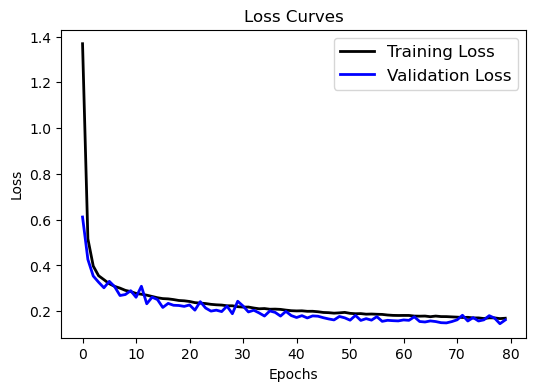

In [101]:
# Plotting the loss curve
plt.figure(figsize=[6, 4])
plt.plot(history.history['loss'], 'black', linewidth=2.0)
plt.plot(history.history['val_loss'], 'blue', linewidth=2.0)
plt.legend(['Training Loss', 'Validation Loss'], fontsize=12)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Loss Curves', fontsize=12)

Text(0.5, 1.0, 'Accuracy Curves')

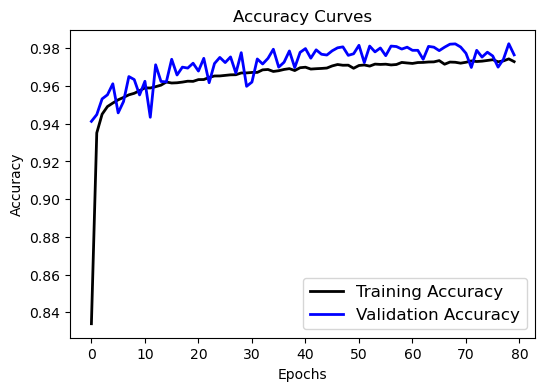

In [102]:
# Plotting the accuracy curve
plt.figure(figsize=[6, 4])
plt.plot(history.history['accuracy'], 'black', linewidth=2.0)
plt.plot(history.history['val_accuracy'], 'blue', linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=12)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.title('Accuracy Curves', fontsize=12)

### Saving model to file

In [103]:
import json

with open('models/checkpoints/mnist_model_best_history.json', 'w') as f:
  json.dump(history.history, f)